# CS 437/5317 Deep Learning - Tutorial 3

## Generators in Python

In [6]:
def make_sequence1(n):
    l = []
    i = 0
    while i < n:
        l.append(i)
        i += 1
    return l

for number in make_sequence1(5):
    print(number)

0
1
2
3
4


In [7]:
def make_sequence2(n):
    i = 0
    while i < n:
        yield i
        i += 1

for number in make_sequence2(5):
    print(number)

0
1
2
3
4


In [8]:
%%timeit
sum(make_sequence1(500))

263 µs ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%%timeit
sum(make_sequence2(500))

150 µs ± 36.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


__Let's see a simpler more elaborated example__

In [18]:
def gen_func():
    print('inside 1')
    yield 'alpha'
    print('inside 2')
    yield 'beta'

for x in gen_func():
    print('outside')
    print(x)

inside 1
outside
alpha
inside 2
outside
beta


__C++ has IO Streams and functional languages like Haskell/Closure have lazy evaluation.__

__You can use Python generators to achieve both those things.__

In [14]:
with open('test.txt', 'r') as f:
    lines_striped = (l.strip() for l in f)
    words = (l.split() for l in lines_striped)
    words = (w.lower() for l in words for w in l)
    vocab = set(words)

## Imports

In [29]:
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model, to_categorical
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import display

import cv2
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import os

## Hyperparameters

In [22]:
batch_size = 32
num_classes = 10
class_labels = np.arange(0, num_classes, 1)
epochs = 3
input_shape = (28,28,1)

images_dir = 'images/'
model_name = 'tutorial_model'
if not os.path.exists('./'+model_name):
    os.mkdir(model_name)

np.random.seed(42)

## Load Data (Generators)

In [3]:
full_data = pd.read_csv('dataset.csv')
print(full_data.shape)
full_data.head()

(280, 2)


,filename,class
0,abd,0
1,asd,1
2,asfwqe,2
3,werfd,3
4,scv,4


In [4]:
train_set, test_set = train_test_split(full_data, test_size=0.2, shuffle=True)
train_set, val_set = train_test_split(train_set, test_size=0.2, shuffle=True)

print(train_set.shape[0], 'train samples')
print(val_set.shape[0], 'validation samples')
print(test_set.shape[0], 'test samples')

179 train samples
45 validation samples
56 test samples


In [5]:
def get_sample(sample):
    im = cv2.cvtColor(cv2.imread(images_dir+sample['filename']+'.jpg'), cv2.COLOR_BGR2RGB)
    # any resizing / cropping here
    im = im.reshape(input_shape)
    im = im / 255.0
    
    label = np.zeros((num_classes,), dtype='int')
    label[sample['class']] = 1
    
    return im, label
    
def data_generator(df, batch_size):
    indexes = np.arange(0, len(df), batch_size)
    
    # Last value removed to prevent creation of a batch with size < batch_size 
    # incase the dataset can not be divided into the correct number of batches
    # given the predefined batch_size
    # This approach effectively reduces the number of batches by 1
    
    # So 5 if the len(df)/batchsize == 5.5
    # instead of 6 which could be done if I replicated samples
    
    if len(df) % batch_size != 0:
        indexes = indexes[:-1] 
    
    while True: # 1 iteration represents 1 epoch
        np.random.shuffle(indexes) # indexes shuffled for each epoch
        for index in indexes: # 1 iteration represents 1 batch
            batch_examples = df.iloc[index : index+batch_size].reset_index()
                        
            Xs = np.zeros((batch_size, *input_shape))
            Ys = np.zeros((batch_size, num_classes))
            for index, row in batch_examples.iterrows():
                x, y = get_sample(row)
                Xs[index, :, :, :] = x
                Ys[index, :] = y
            yield Xs, Ys

In [17]:
train_gen = data_generator(train_set, batch_size)
val_gen = data_generator(val_set, batch_size)
test_gen = data_generator(test_set, batch_size)

## Build Model (Functional API + Layers API)

In [23]:
input_im = Input(shape=(input_shape), name='input_im')

l = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_im)
l = Conv2D(64, (3, 3), activation='relu')(l)
l = MaxPooling2D(pool_size=(2, 2))(l)
l = Dropout(rate=0.25)(l)
l = Flatten()(l)
l = Dense(128, activation='relu')(l)
l = Dropout(rate=0.5)(l)
output_class = Dense(num_classes, activation='softmax')(l)

model = Model(inputs=input_im, outputs=output_class)

In [24]:
adam = Adam(lr=1e-3)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam, 
              metrics=['accuracy'])

plot_model(model, model_name+'/'+model_name+'.png')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_im (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
__________

## Training

In [8]:
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

In [9]:
checkpoint = ModelCheckpoint(model_name+'/'+model_name+'-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000001, min_delta=0.03)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=1, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)

callbacks = [checkpoint, tensorboard, cvslogger, reducelr]

In [ ]:
hist = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_set)//batch_size, 
                           validation_data=val_gen, validation_steps=len(val_set)//batch_size, 
                           callbacks=callbacks, verbose=1)

## Visualization of Model parameters

### Tensorboard (computation graph + parameter distribution)

The computations you'll use TensorFlow for - like training a massive deep neural network - can be complex and confusing. To make it easier to understand, debug, and optimize TensorFlow programs, we've included a suite of visualization tools called TensorBoard. You can use TensorBoard to visualize your TensorFlow graph, plot quantitative metrics about the execution of your graph, and show additional data like images that pass through it. When TensorBoard is fully configured, it looks like this:
![](https://www.tensorflow.org/images/mnist_tensorboard.png)

You can run TensorBoard using teh following command
```tensorboard --logdir=path/to/log-directory
```

*Note: TensorBoard does not like to see multiple event files in the same directory. This can lead to you getting very gruesome curves on the display. So you should create a separate folder for each different example (for example, `summaries/first`, `summaries/second`, ...) to save data.*

*Another thing to keep in mind is that, if you want to re-run an experiment (that is, saving an event file to an already populated folder), you have to make sure to first delete the existing event files.*

### Learned Filters

In [25]:
model.load_weights('tutorial_model_mnist/tutorial_model_mnist-15-0.03.h5')

In [26]:
model.weights

[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv2d_1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/kernel:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(9216, 128) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(128, 10) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(10,) dtype=float32_ref>]

In [27]:
w1 = model.get_weights()[0]
w1.shape

(3, 3, 1, 32)

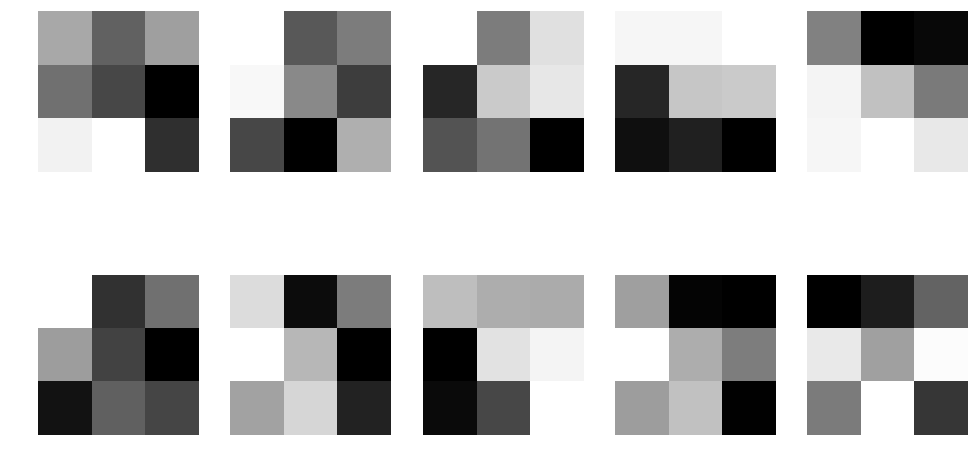

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,8), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(w1[:,:,0,i]);
    ax.grid(False);
    ax.axis('off');

### Layer Activations

In [31]:
_, (x_test, y_test) = mnist.load_data()

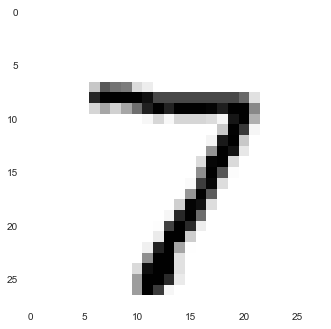

In [34]:
plt.imshow(x_test[0,:,:]);
plt.gca().grid(False);

In [42]:
model.predict(x_test[0,:,:].reshape((1,28,28,1))).argmax(axis=1)

array([7], dtype=int64)

In [39]:
new_model = Model(inputs=input_im, 
                  outputs=model.get_layer('conv2d_1').output)

In [49]:
con1_activations = new_model.predict(x_test[0,:,:].reshape((1,28,28,1)))
con1_activations.shape

(1, 26, 26, 32)

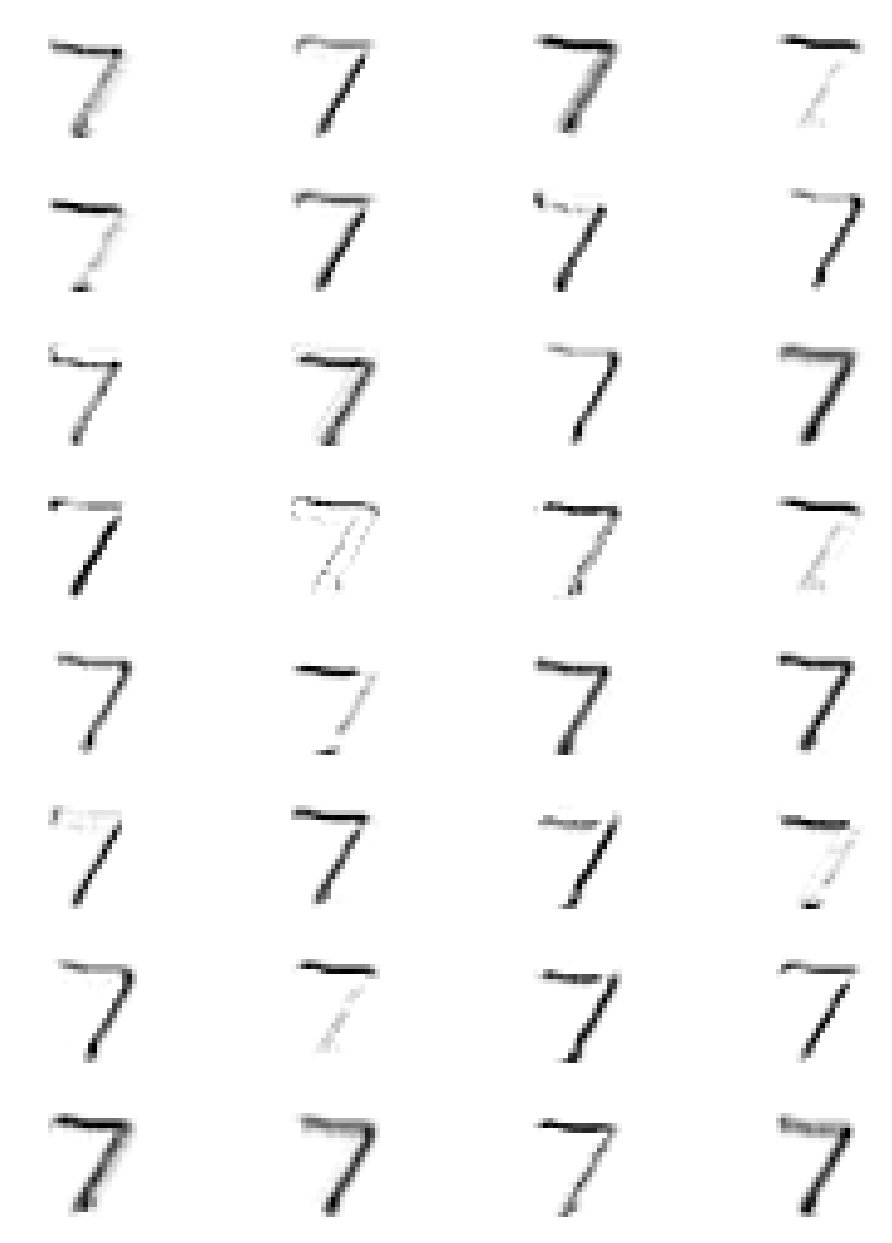

In [50]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,20), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(con1_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');

In [51]:
new_model = Model(inputs=input_im, 
                  outputs=model.get_layer('conv2d_2').output)

In [52]:
con1_activations = new_model.predict(x_test[0,:,:].reshape((1,28,28,1)))
con1_activations.shape

(1, 24, 24, 64)

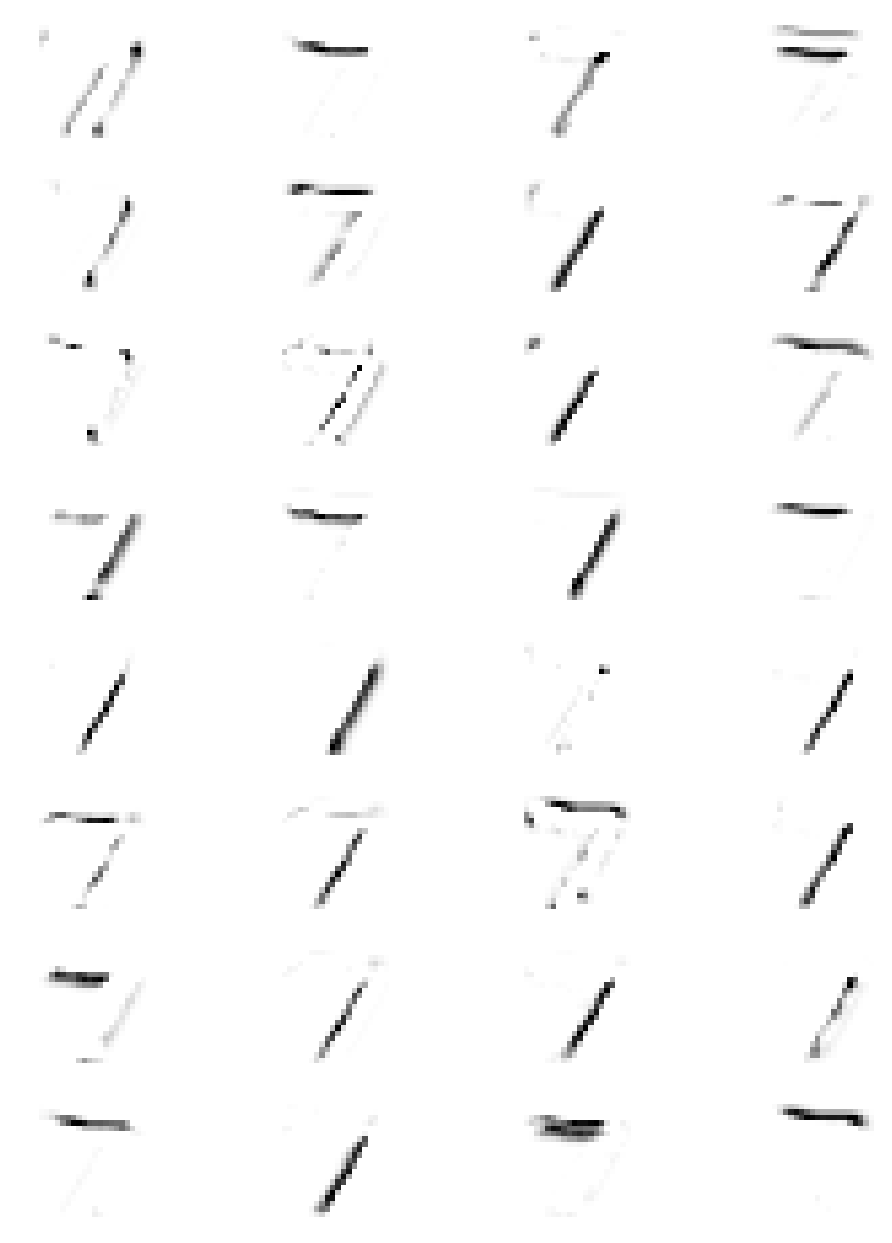

In [53]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(15,20), dpi=80)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(con1_activations[0,:,:,i]);
    ax.grid(False);
    ax.axis('off');